In [1]:
!pip install -q diffusers transformers accelerate bitsandbytes sentencepiece ftfy gradio torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121


import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm.auto import tqdm
import json
import random
import numpy as np
from google.colab import drive
from accelerate import Accelerator
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers.optimization import get_scheduler
from transformers import CLIPTextModel, CLIPTokenizer, BlipProcessor, BlipForConditionalGeneration, GPT2Config, GPT2LMHeadModel, AutoTokenizer
from peft import LoraConfig
import bitsandbytes as bnb
import torch.nn as nn

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Libraries installed and imported successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DRIVE_BASE_PATH = "/content/drive/My Drive/"
DATASET_FOLDER_NAME = "painting"
OUTPUT_FOLDER_NAME = "colab_outputs/painting_style_model"

DATASET_PATH = os.path.join(DRIVE_BASE_PATH, "datasets", DATASET_FOLDER_NAME)
OUTPUT_DIR = os.path.join(DRIVE_BASE_PATH, OUTPUT_FOLDER_NAME)

# --- CHECKPOINTING: Define paths to save progress ---
LORA_CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoints_lora")
CAPTIONER_CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoints_captioner")


# --- Style Configuration ---
STYLE_NAME = "painting"
STYLE_TRIGGER = "style_painting"

# --- Model Configuration ---
MODEL_NAME = "runwayml/stable-diffusion-v1-5"
CAPTIONING_MODEL_NAME = "Salesforce/blip-image-captioning-large"

# --- T4 Optimized Training Parameters ---
IMAGE_RESOLUTION = 512
BATCH_SIZE = 2
GRADIENT_ACCUMULATION_STEPS = 4
LEARNING_RATE_LORA = 2e-4
NUM_TRAIN_EPOCHS_LORA = 10
LORA_RANK = 16
MIXED_PRECISION = "fp16"

# --- Output Configuration ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LORA_CHECKPOINT_DIR, exist_ok=True)
os.makedirs(CAPTIONER_CHECKPOINT_DIR, exist_ok=True)
METADATA_FILE = os.path.join(OUTPUT_DIR, "metadata.jsonl")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("--- Configuration ---")
print(f"Dataset path: {DATASET_PATH}")
print(f"Output path: {OUTPUT_DIR}")
print(f"LoRA Checkpoint path: {LORA_CHECKPOINT_DIR}")
print("---------------------")

--- Configuration ---
Dataset path: /content/drive/My Drive/datasets/painting
Output path: /content/drive/My Drive/colab_outputs/painting_style_model
LoRA Checkpoint path: /content/drive/My Drive/colab_outputs/painting_style_model/checkpoints_lora
---------------------


In [4]:
# --- Cell 3: Image Preprocessing and Caption Generation with BLIP ---

print("Initializing BLIP model for caption generation...")
# Load the BLIP processor and model
blip_processor = BlipProcessor.from_pretrained(CAPTIONING_MODEL_NAME)
blip_model = BlipForConditionalGeneration.from_pretrained(CAPTIONING_MODEL_NAME).to(DEVICE)
print("BLIP model loaded.")

image_files = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Check if metadata file already exists to avoid re-generating
if os.path.exists(METADATA_FILE) and os.path.getsize(METADATA_FILE) > 0:
    print(f"'{METADATA_FILE}' already exists. Skipping caption generation.")
    with open(METADATA_FILE, 'r') as f:
        metadata = [json.loads(line) for line in f]
else:
    print(f"Generating captions for {len(image_files)} images. This may take a while...")
    metadata = []
    with open(METADATA_FILE, 'w') as f:
        for image_path in tqdm(image_files, desc="Captioning Images"):
            try:
                raw_image = Image.open(image_path).convert("RGB")

                # Generate base caption (e.g., "a man with a beard")
                inputs = blip_processor(raw_image, return_tensors="pt").to(DEVICE)
                out = blip_model.generate(**inputs, max_new_tokens=50)
                base_caption = blip_processor.decode(out[0], skip_special_tokens=True)

                # Create the style-aware caption for training
                # This format helps the model associate the trigger word with both content and style
                # Example: "An engraving in the style of style_engraving, depicting a man with a beard"
                final_caption = f"An {STYLE_NAME.lower()} in the style of {STYLE_TRIGGER}, depicting {base_caption}"

                record = {"file_name": image_path, "text": final_caption}
                metadata.append(record)
                f.write(json.dumps(record) + "\n")

            except Exception as e:
                print(f"Could not process {image_path}: {e}")

# Display a sample from our newly created dataset
print("\n--- Sample from generated metadata ---")
if metadata:
    print(json.dumps(metadata[0], indent=2))
else:
    print("No metadata was generated. Please check your DATASET_PATH.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Initializing BLIP model for caption generation...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

BLIP model loaded.
'/content/drive/My Drive/colab_outputs/painting_style_model/metadata.jsonl' already exists. Skipping caption generation.

--- Sample from generated metadata ---
{
  "file_name": "/content/drive/My Drive/datasets/painting/0342.jpg",
  "text": "An painting in the style of style_painting, depicting portrait of a man in a green coat and a gold frame"
}


In [5]:
# --- Cell 4: Custom Dataset for LoRA Training ---

class DreamBoothDataset(Dataset):
    def __init__(self, metadata, tokenizer, size=512):
        self.metadata = metadata
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        item = self.metadata[index]
        image = Image.open(item["file_name"]).convert("RGB")
        pixel_values = self.transforms(image)
        input_ids = self.tokenizer(
            item["text"],
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt"
        ).input_ids

        return {"pixel_values": pixel_values, "input_ids": input_ids.squeeze(0)}

# Initialize tokenizer
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")

# Create the dataset and dataloader
train_dataset_lora = DreamBoothDataset(metadata, tokenizer, size=IMAGE_RESOLUTION)
train_dataloader_lora = DataLoader(train_dataset_lora, batch_size=BATCH_SIZE, shuffle=True)

print(f"LoRA training dataset created with {len(train_dataset_lora)} samples.")

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

LoRA training dataset created with 2042 samples.


In [9]:
# --- Cell 6: LoRA Training Loop (with Robust Checkpointing) ---

# Initialize Accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    mixed_precision=MIXED_PRECISION,
    log_with="tensorboard",
    project_dir=os.path.join(OUTPUT_DIR, "logs")
)

# Load models in standard float32 precision
text_encoder = CLIPTextModel.from_pretrained(MODEL_NAME, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(MODEL_NAME, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(MODEL_NAME, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(MODEL_NAME, subfolder="tokenizer")
noise_scheduler = PNDMScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")

# Add LoRA adapter
lora_config = LoraConfig(r=LORA_RANK, lora_alpha=LORA_RANK, target_modules=["to_q", "to_k", "to_v", "to_out.0", "proj_in", "proj_out"])
unet.add_adapter(lora_config)

# Memory savings
unet.enable_gradient_checkpointing()
unet.set_attention_slice("auto")
print("Using memory-efficient attention slicing and gradient checkpointing.")


# Create dataset and dataloader
with open(METADATA_FILE, 'r') as f:
    metadata = [json.loads(line) for line in f]
train_dataset = DreamBoothDataset(metadata, tokenizer, size=IMAGE_RESOLUTION)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Optimizer and Scheduler
optimizer = bnb.optim.AdamW8bit(filter(lambda p: p.requires_grad, unet.parameters()), lr=LEARNING_RATE_LORA)
lr_scheduler = get_scheduler("cosine", optimizer=optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataloader) * NUM_TRAIN_EPOCHS_LORA))

# Prepare with accelerator
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(unet, optimizer, train_dataloader, lr_scheduler)
vae.to(accelerator.device, dtype=torch.float16)
text_encoder.to(accelerator.device, dtype=torch.float16)

# --- ROBUST CHECKPOINTING: Load state if checkpoint exists ---
if os.path.exists(LORA_CHECKPOINT_DIR) and len(os.listdir(LORA_CHECKPOINT_DIR)) > 0:
    print("Resuming from checkpoint...")
    checkpoint_dirs = [d for d in os.listdir(LORA_CHECKPOINT_DIR) if d.startswith('epoch_')]
    if checkpoint_dirs:
        latest_epoch = max([int(d.split('_')[1]) for d in checkpoint_dirs])
        latest_checkpoint_dir = os.path.join(LORA_CHECKPOINT_DIR, f"epoch_{latest_epoch}")

        # --- FIX: Check if the crucial LoRA weights file exists before trying to load ---
        lora_weights_file = os.path.join(latest_checkpoint_dir, "pytorch_lora_weights.safetensors")
        if os.path.exists(lora_weights_file):
            accelerator.load_state(latest_checkpoint_dir)
            # --- FIX: Explicitly load the LoRA weights into the UNet model ---
            unet.load_attn_procs(latest_checkpoint_dir)
            first_epoch = latest_epoch
            print(f"Resumed successfully from epoch {first_epoch}")
        else:
            print(f"Corrupted checkpoint found at epoch {latest_epoch}. Please delete it and restart.")
            # Set a high epoch number to prevent the loop from running
            first_epoch = NUM_TRAIN_EPOCHS_LORA
    else:
        first_epoch = 0
        print("No valid epoch checkpoints found. Starting new training run.")
else:
    print("Starting new training run.")
    first_epoch = 0


print("Starting LoRA training...")
for epoch in range(first_epoch, NUM_TRAIN_EPOCHS_LORA):
    unet.train()
    progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}")
    if epoch == first_epoch and first_epoch > 0:
        resume_step = accelerator.step % len(train_dataloader)
        progress_bar.update(resume_step)

    for step, batch in enumerate(train_dataloader):
        if epoch == first_epoch and first_epoch > 0 and step < resume_step:
            continue

        with accelerator.accumulate(unet):
            with torch.no_grad():
                latents = vae.encode(batch["pixel_values"].to(dtype=torch.float16)).latent_dist.sample()
                latents = latents * vae.config.scaling_factor
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

            noise = torch.randn_like(latents)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.detach().item())

    # --- ROBUST CHECKPOINTING: Save state and LoRA weights separately ---
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        epoch_checkpoint_dir = os.path.join(LORA_CHECKPOINT_DIR, f"epoch_{epoch+1}")
        os.makedirs(epoch_checkpoint_dir, exist_ok=True)

        # Save the full training state (optimizer, scheduler, etc.)
        accelerator.save_state(epoch_checkpoint_dir)

        # --- FIX: Explicitly save the LoRA weights in the same folder ---
        unwrapped_unet = accelerator.unwrap_model(unet)
        unwrapped_unet.save_attn_procs(epoch_checkpoint_dir, safe_serialization=True, weight_name="pytorch_lora_weights.safetensors")

        print(f"Checkpoint and LoRA weights saved for epoch {epoch + 1} at {epoch_checkpoint_dir}")


# --- SAVING THE FINAL WEIGHTS ---
print("Saving final LoRA weights...")
unwrapped_unet = accelerator.unwrap_model(unet)
unwrapped_unet.save_attn_procs(OUTPUT_DIR, safe_serialization=True, weight_name="pytorch_lora_weights.safetensors")
print(f"Final LoRA weights saved successfully to: {OUTPUT_DIR}")
print("LoRA training finished.")

Using memory-efficient attention slicing and gradient checkpointing.
Resuming from checkpoint...
Corrupted checkpoint found at epoch 5. Please delete it and restart.
Starting LoRA training...
Saving final LoRA weights...
Final LoRA weights saved successfully to: /content/drive/My Drive/colab_outputs/painting_style_model
LoRA training finished.


In [12]:
# --- Cell 6: Captioner Model and Dataset ---

# 1. Define the Captioner Model (a simple GPT-2-like Transformer Decoder)
class LatentCaptioner(nn.Module):
    def __init__(self, latent_dim, vocab_size, embed_dim=768, num_heads=8, num_layers=4):
        super().__init__()
        self.latent_dim = latent_dim
        self.vocab_size = vocab_size

        # Project the flat latent noise into the model's embedding dimension
        self.latent_projection = nn.Linear(latent_dim, embed_dim)

        # Standard GPT-2 components
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
        self.tokenizer.pad_token = self.tokenizer.eos_token

        config = GPT2Config(
            vocab_size=self.tokenizer.vocab_size,
            n_embd=embed_dim,
            n_head=num_heads,
            n_layer=num_layers,
            n_positions=1024, # max sequence length
        )
        self.transformer = GPT2LMHeadModel(config)

        # Adjust the model to accept our projected latent as a prefix
        self.transformer.config.add_cross_attention = True # This isn't used directly but signals intent

    def forward(self, input_ids, latent_noise, attention_mask=None, labels=None):
        # Flatten the latent noise: (batch, 4, 64, 64) -> (batch, 16384)
        flat_latent = latent_noise.view(latent_noise.shape[0], -1)

        # Project latent to embedding dimension and treat as a prefix
        latent_embedding = self.latent_projection(flat_latent).unsqueeze(1) # (batch, 1, embed_dim)

        # Get token embeddings
        token_embeddings = self.transformer.transformer.wte(input_ids) # (batch, seq_len, embed_dim)

        # Concatenate latent prefix and token embeddings
        embeddings = torch.cat([latent_embedding, token_embeddings], dim=1)

        # Create a combined attention mask
        if attention_mask is not None:
            # Add a '1' for the latent prefix
            prefix_mask = torch.ones(attention_mask.shape[0], 1, device=attention_mask.device)
            combined_attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
        else:
            combined_attention_mask = None

        # Pass through the transformer
        outputs = self.transformer(
            inputs_embeds=embeddings,
            attention_mask=combined_attention_mask,
            labels=None # We will calculate loss manually
        )

        # Calculate loss if labels are provided
        loss = None
        if labels is not None:
            # Shift logits and labels for next token prediction
            # We must ignore the logit corresponding to the latent prefix
            logits = outputs.logits[:, :-1, :].contiguous()
            shift_labels = labels.contiguous()

            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), shift_labels.view(-1))

        return {"loss": loss, "logits": outputs.logits}

# 2. Define the Dataset for the Captioner
class CaptionerDataset(Dataset):
    def __init__(self, metadata, tokenizer, latent_shape=(4, 64, 64)):
        self.metadata = metadata
        self.tokenizer = tokenizer
        self.latent_shape = latent_shape
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        # Generate a random noise tensor for each item on the fly
        # This is the "seed"
        latent_noise = torch.randn(self.latent_shape)

        # Get the corresponding caption
        caption = self.metadata[index]["text"]
        tokenized = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=77, # Standard SD length
            return_tensors="pt"
        )
        input_ids = tokenized.input_ids.squeeze(0)
        attention_mask = tokenized.attention_mask.squeeze(0)

        # The labels are the same as input_ids for language modeling
        labels = input_ids.clone()

        return {
            "latent_noise": latent_noise,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# Initialize model and dataset
latent_dim = 4 * (IMAGE_RESOLUTION // 8) * (IMAGE_RESOLUTION // 8)
captioner = LatentCaptioner(latent_dim=latent_dim, vocab_size=50257).to(DEVICE)
captioner_dataset = CaptionerDataset(metadata, captioner.tokenizer)
captioner_dataloader = DataLoader(captioner_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Captioner model and dataset are ready.")
print(f"Latent dimension: {latent_dim}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Captioner model and dataset are ready.
Latent dimension: 16384


In [13]:
NUM_TRAIN_EPOCHS_CAPTIONER = 30
LEARNING_RATE_CAPTIONER = 3e-5
CAPTIONER_MODEL_PATH = os.path.join(OUTPUT_DIR, "captioner_model.pth")

# Use a standard AdamW optimizer for the captioner
optimizer_captioner = torch.optim.AdamW(captioner.parameters(), lr=LEARNING_RATE_CAPTIONER)

# Prepare everything with the same accelerator
captioner, optimizer_captioner, captioner_dataloader = accelerator.prepare(
    captioner, optimizer_captioner, captioner_dataloader
)

# --- Checkpointing for the Captioner ---
if os.path.exists(CAPTIONER_CHECKPOINT_DIR) and len(os.listdir(CAPTIONER_CHECKPOINT_DIR)) > 0:
    print("Resuming captioner training from checkpoint...")
    accelerator.load_state(CAPTIONER_CHECKPOINT_DIR)
else:
    print("Starting new captioner training run.")


print("Starting Captioner training...")
for epoch in range(NUM_TRAIN_EPOCHS_CAPTIONER):
    captioner.train()
    progress_bar = tqdm(total=len(captioner_dataloader), desc=f"Captioner Epoch {epoch + 1}")

    for step, batch in enumerate(captioner_dataloader):
        with accelerator.accumulate(captioner):
            # The batch is already on the correct device thanks to accelerator
            outputs = captioner(
                input_ids=batch["input_ids"],
                latent_noise=batch["latent_noise"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"]
            )

            loss = outputs["loss"]

            accelerator.backward(loss)

            optimizer_captioner.step()
            optimizer_captioner.zero_grad()

        progress_bar.update(1)
        progress_bar.set_postfix(loss=loss.detach().item())

    # --- Save a checkpoint after each epoch ---
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        accelerator.save_state(CAPTIONER_CHECKPOINT_DIR)
        print(f"Captioner checkpoint saved for epoch {epoch + 1}")

# --- SAVING THE FINAL CAPTIONER MODEL ---
print("Saving final Captioner model...")
unwrapped_captioner = accelerator.unwrap_model(captioner)
accelerator.save(unwrapped_captioner.state_dict(), CAPTIONER_MODEL_PATH)

print(f"Captioner model saved successfully to: {CAPTIONER_MODEL_PATH}")
print("Captioner training finished.")


Starting new captioner training run.
Starting Captioner training...


Captioner Epoch 1:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 1


Captioner Epoch 2:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 2


Captioner Epoch 3:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 3


Captioner Epoch 4:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 4


Captioner Epoch 5:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 5


Captioner Epoch 6:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 6


Captioner Epoch 7:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 7


Captioner Epoch 8:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 8


Captioner Epoch 9:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 9


Captioner Epoch 10:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 10


Captioner Epoch 11:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 11


Captioner Epoch 12:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 12


Captioner Epoch 13:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 13


Captioner Epoch 14:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 14


Captioner Epoch 15:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 15


Captioner Epoch 16:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 16


Captioner Epoch 17:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 17


Captioner Epoch 18:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 18


Captioner Epoch 19:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 19


Captioner Epoch 20:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 20


Captioner Epoch 21:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 21


Captioner Epoch 22:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 22


Captioner Epoch 23:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 23


Captioner Epoch 24:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 24


Captioner Epoch 25:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 25


Captioner Epoch 26:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 26


Captioner Epoch 27:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 27


Captioner Epoch 28:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 28


Captioner Epoch 29:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 29


Captioner Epoch 30:   0%|          | 0/2042 [00:00<?, ?it/s]

Captioner checkpoint saved for epoch 30
Saving final Captioner model...
Captioner model saved successfully to: /content/drive/My Drive/colab_outputs/painting_style_model/captioner_model.pth
Captioner training finished.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Image generation pipeline with LoRA weights is ready.
Accurate captioning model (BLIP) is ready.


  0%|          | 0/30 [00:00<?, ?it/s]

`cache.key_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].keys` instead.
`cache.value_cache[idx]` is deprecated and will be removed in v4.56.0. Use `cache.layers[idx].values` instead.



--- Test Generation ---
Generated Caption: painting of a lion with a long mane and a big nose


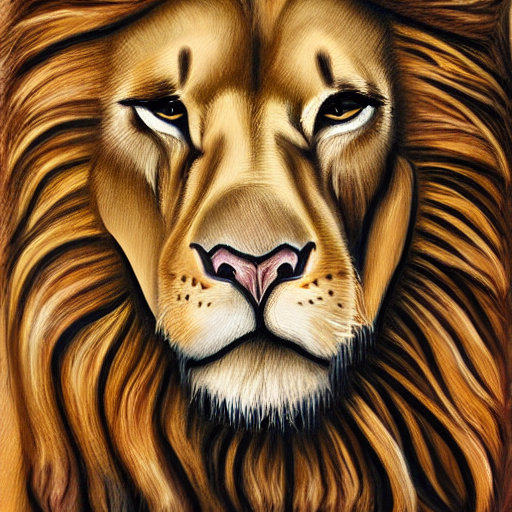

In [24]:
from diffusers import StableDiffusionPipeline
import torch

# --- 1. Load the Base Pipeline and Trained LoRA Weights ---
pipe = StableDiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16).to(accelerator.device)
lora_weights_path = os.path.join(OUTPUT_DIR, "pytorch_lora_weights.safetensors")
pipe.load_lora_weights(OUTPUT_DIR, weight_name="pytorch_lora_weights.safetensors")
print("Image generation pipeline with LoRA weights is ready.")

# --- 2. Load the Pre-trained BLIP Model for Accurate Captioning ---
# --- FIX: We will use the original, powerful BLIP model for captioning ---
# This ensures the generated captions are accurate to the final image.
blip_processor = BlipProcessor.from_pretrained(CAPTIONING_MODEL_NAME)
blip_model = BlipForConditionalGeneration.from_pretrained(CAPTIONING_MODEL_NAME, torch_dtype=torch.float16).to(accelerator.device)
blip_model.eval()
print("Accurate captioning model (BLIP) is ready.")


# --- 3. Define the Generation Function ---
def generate_multimodal_output(prompt, seed):
    # Ensure seed is an integer
    seed = int(seed)

    # Generate the latent noise based on the seed
    generator = torch.Generator(device=accelerator.device).manual_seed(seed)

    # --- Generate Image ---
    full_prompt = f"{prompt}, in the style of {STYLE_TRIGGER}"

    image = pipe(
        prompt=full_prompt,
        generator=generator, # Use the seeded generator for reproducibility
        num_inference_steps=30,
        guidance_scale=7.5
    ).images[0]

    # --- Generate Accurate Caption from the Final Image ---
    with torch.no_grad():
        # Prepare the generated image for the BLIP model
        inputs = blip_processor(images=image, return_tensors="pt").to(accelerator.device, dtype=torch.float16)

        # Generate caption IDs
        output_ids = blip_model.generate(**inputs, max_new_tokens=77)

        # Decode the IDs into a text caption
        caption = blip_processor.decode(output_ids[0], skip_special_tokens=True)

    return {"image": image, "caption": caption}

# --- Test the function with a seed and a prompt ---
result = generate_multimodal_output("A majestic lion", 42)
print("\n--- Test Generation ---")
print(f"Generated Caption: {result['caption']}")
result['image']

In [27]:
import gradio as gr
import random

def gradio_interface(prompt, seed):
    # Gradio inputs are strings or floats, so convert to int
    seed = int(seed)
    # The generation function is already defined in the previous cell
    result = generate_multimodal_output(prompt, seed)
    return result['image'], result['caption']

# --- Function for the new "Random Seed" button ---
def get_random_seed():
    return random.randint(0, 2**32 - 1)


# --- Create the Gradio interface ---
css = """
body {
    background: linear-gradient(120deg, #1f2937, #374151, #4b5563);
    background-size: 200% 200%;
    animation: gradient 15s ease infinite;
}
@keyframes gradient {
    0% {background-position: 0% 50%;}
    50% {background-position: 100% 50%;}
    100% {background-position: 0% 50%;}
}
.gradio-container {
    border-radius: 20px !important;
    background-color: rgba(255, 255, 255, 0.05) !important;
    backdrop-filter: blur(10px);
}
.gr-button {
    background: linear-gradient(90deg, #4f46e5, #a855f7);
    color: white;
    border: none;
    border-radius: 8px;
    box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
    transition: all 0.2s ease-in-out;
}
.gr-button:hover {
    transform: translateY(-2px);
    box-shadow: 0 6px 12px rgba(0, 0, 0, 0.2);
}
.gr-input {
    border-radius: 8px !important;
}
.gr-image {
    border-radius: 12px !important;
    box-shadow: 0 8px 25px rgba(0,0,0,0.2);
}
"""

with gr.Blocks(theme=gr.themes.Soft(), css=css) as demo:
    gr.Markdown(f"<h1 style='text-align: center; color: white;'>🎨 Unified Multimodal {STYLE_NAME.title()} Generator 🎨</h1>")
    gr.Markdown("<p style='text-align: center; color: #d1d5db;'>Enter a prompt and a seed to generate a unique, stylized image and an accurate caption describing it.</p>")

    with gr.Row(elem_id="main-row"):
        with gr.Column(scale=1):
            prompt_input = gr.Textbox(label="Prompt", value="A majestic lion", lines=3, placeholder="Describe the image you want to create...")

            with gr.Row():
                seed_input = gr.Number(label="Seed", value=42, precision=0)
                random_seed_btn = gr.Button("🎲")

            generate_btn = gr.Button("✨ Generate ✨", variant="primary")

        with gr.Column(scale=2):
            output_image = gr.Image(label="Generated Image")
            output_caption = gr.Textbox(label="Generated Caption", interactive=False)

    # --- Define the behavior of the buttons ---
    generate_btn.click(
        fn=gradio_interface,
        inputs=[prompt_input, seed_input],
        outputs=[output_image, output_caption]
    )

    random_seed_btn.click(
        fn=get_random_seed,
        inputs=[],
        outputs=seed_input
    )

# Launch the demo
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ba5b5da8d41347552e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Loading LoRA weights from: /content/drive/My Drive/colab_outputs/painting_style_model/pytorch_lora_weights.safetensors


  0%|          | 0/30 [00:00<?, ?it/s]

Generated Image:


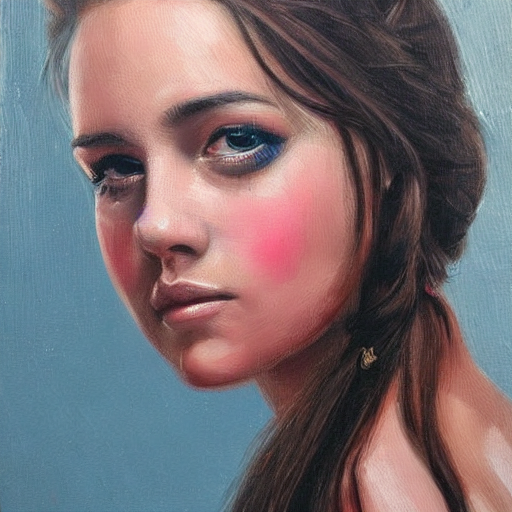

In [11]:
# --- Cell 9: Model Inference and Testing ---
from diffusers import StableDiffusionPipeline
import torch

# --- 1. Load the Base Model ---
# Make sure MODEL_NAME is the same as in your config cell
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16
).to(accelerator.device)

# --- 2. Load Your Trained LoRA Weights ---
# The weights are saved in your main output directory
lora_weights_path = os.path.join(OUTPUT_DIR, "pytorch_lora_weights.safetensors")

if os.path.exists(lora_weights_path):
    print(f"Loading LoRA weights from: {lora_weights_path}")
    # The `pipe.load_lora_weights` method handles loading and applying the style
    pipe.load_lora_weights(OUTPUT_DIR, weight_name="pytorch_lora_weights.safetensors")
else:
    print("Could not find LoRA weights. Make sure at least one epoch has finished and saved.")


# --- 3. Generate an Image ---
# Use your trigger word in the prompt to activate the style
prompt = f"a ultra realistic potrait of a beutiful young lady with long hair with pretty eyes in the style of {STYLE_TRIGGER}"

# Generate the image
generator = torch.Generator(device=accelerator.device).manual_seed(1024)
image = pipe(prompt, num_inference_steps=30, generator=generator).images[0]

# --- 4. Display the Image ---
print("Generated Image:")
image